In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import re
import nltk
import sklearn

                                                                                                                                                                                                                                                                                                                        
%matplotlib inline

In [2]:
clean_data = pd.read_excel('clean.xlsx')
clean_data = clean_data.iloc[np.random.permutation(len(clean_data))]
clean_data = clean_data.reset_index(drop=True)


In [3]:
clean_data = clean_data[clean_data['Category']!='Hay & Forage']
np.unique(clean_data['Category'])

array([u'Canola', u'Corn', u'Pulse', u'Soybeans', u'Wheat'], dtype=object)

# Preprocessing step

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import enchant
def removenonsensewords(text):
    tokens = nltk.word_tokenize(text)
    d = enchant.Dict("en_US")
    
    stemmed = []
    for token in tokens:
        if d.check(token):
            stemmed.append(token)
        
    return ' '.join(stemmed)

clean_data['Text_Dictionary']= clean_data['Text'].apply(removenonsensewords)

In [4]:
def replacewithstem(text):
    tokens = nltk.word_tokenize(text)
    stemmer = nltk.stem.porter.PorterStemmer()
    
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
        
    return ' '.join(stemmed)

clean_data['Text_Stemmed']= clean_data['Text'].apply(replacewithstem)

In [4]:
text_stemmed = list(clean_data['Text'])

tfidf_stem = TfidfVectorizer(stop_words='english')
train_tfidf = tfidf_stem.fit_transform(text_stemmed)

In [5]:
ch2 = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k = 30)
train_tfidf100 = ch2.fit_transform(train_tfidf, clean_data['Category'])

In [6]:
train_tfidf100.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.02341496,
         0.06259216,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.06053223,
         0.06472515,  0.17469193],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.03681868,
         0.03936902,  0.17709371],
       [ 0.        ,  0.        ,  0.        , ...,  0.11724285,
         0.07521839,  0.15789899],
       [ 0.        ,  0.        ,  0.        , ...,  0.0627388 ,
         0.05590381,  0.        ]])

In [7]:
tfidf2 = TfidfVectorizer(stop_words='english')
train_tfidf2 = tfidf2.fit_transform(clean_data['Text'])

In [8]:
train_tfidf2.shape

(19136, 51617)

In [9]:
train_tfidf.shape

(19136, 39451)

In [10]:
np.save('train_tfidf.npy',train_tfidf)

# Preprocessing alternative 2 - lemmatizing


In [5]:
from nltk.stem import WordNetLemmatizer


def replacewithlemma(text):
    tokens = nltk.word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized = []
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
        
    return ' '.join(lemmatized)

clean_data['Text_lemmatized'] = clean_data['Text'].apply(replacewithlemma)


In [6]:
text_lemmatized = list(clean_data['Text_lemmatized'])

tfidf_lemma = TfidfVectorizer(stop_words='english')
train_lemma = tfidf_lemma.fit_transform(text_lemmatized)

# Preprocessing alternative 3 -- both?

# Feature SELECTION

In [13]:
type(train_lemma)

scipy.sparse.csr.csr_matrix

# Splitting into train, test, validate

In [11]:
train_tfidf

<19136x39451 sparse matrix of type '<type 'numpy.float64'>'
	with 2300155 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_tfidf100, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

# Splitting into train, test, validate -- lemma

In [7]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_lemma, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

In [8]:
data_train.shape

(13777, 47561)

# Trying logistic regression -- l1 = 0.26366508987303555 ---gives 67% accuracy.....not really improved........lemmatization doesnt really improve.......but continue using it

In [26]:
from sklearn.linear_model import LogisticRegression

l1error=[]
l2error=[]
i=0
for c in np.logspace(-5,1,20):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=c, tol=0.01)
    regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.01)
    
    regressionl1.fit(data_train, labels_train)
    regressionl2.fit(data_train, labels_train)
    
    l1error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    
    l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


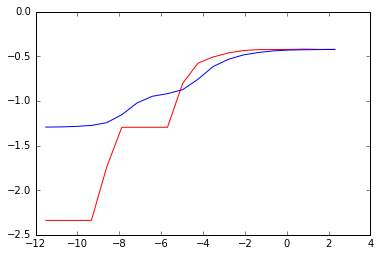

In [27]:
plt.plot(*zip(*np.log(l1error)),c='r')
plt.plot(*zip(*np.log(l2error)),c='b')

In [28]:
l1error.sort(key=lambda tup: tup[1])
l1error[-1]

(2.3357214690901213, 0.6570553712681807)

In [29]:
l2error.sort(key=lambda tup: tup[1])
l2error[-1]

(10.0, 0.65399336565450372)

# Trying without stemming --minor reduction in accuracy

In [15]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_tfidf2, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

NameError: name 'train_tfidf2' is not defined

In [16]:
from sklearn.linear_model import LogisticRegression

l1error=[]
l2error=[]
i=0
for c in np.logspace(-2,2,20):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    regressionl1 = LogisticRegression(penalty='l1', C=c, tol=0.01)
    regressionl2 = LogisticRegression(penalty='l2', C=c, tol=0.01)
    
    regressionl1.fit(data_train, labels_train)
    regressionl2.fit(data_train, labels_train)
    
    l1error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl1.predict(data_validation), normalize=True)))
    
    l2error.append((c,sklearn.metrics.accuracy_score(labels_validation,regressionl2.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


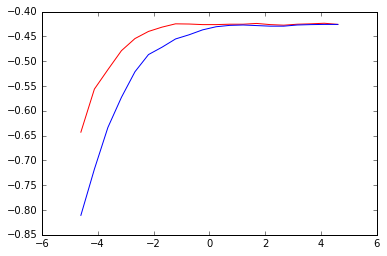

In [17]:
plt.plot(*zip(*np.log(l1error)),c='r')
plt.plot(*zip(*np.log(l2error)),c='b')

In [18]:
l1error.sort(key=lambda tup: tup[1])
l1error[-1]

(61.584821106602604, 0.65475886705792297)

In [19]:
l2error.sort(key=lambda tup: tup[1])
l2error[-1]

(100.0, 0.65322786425108448)

# Try random forest on stemmed data -- takes too long to compute, when tried with 5 trees gives 40% accuracy

In [30]:
from sklearn.cross_validation import train_test_split

data_train_and_validation, data_test, labels_train_and_validation, labels_test = train_test_split(train_tfidf, clean_data['Category'], test_size = 0.10, random_state = 0)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_and_validation, labels_train_and_validation, test_size = 0.20, random_state = 0)

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:


scores_validation = []
scores_train = []
for i in xrange(5,25,5):
    print(i)
    forest = RandomForestClassifier(n_estimators = i)
    forest = forest.fit(data_train, labels_train)
    
    results_validation = forest.predict(data_validation)
    curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
    
    results_train = forest.predict(data_train)
    curr_score_train = sklearn.metrics.accuracy_score(labels_train, results_train, normalize=True)
    
    scores_validation.append((i,curr_score_valid))
    scores_train.append((i,curr_score_train))

5


KeyboardInterrupt: 

In [ ]:
plt.scatter(*zip(*scores_train),c='r')
plt.scatter(*zip(*scores_validation),c='b')

In [ ]:
forest = RandomForestClassifier(n_estimators = 5)
forest = forest.fit(data_train, labels_train)
    
results_validation = forest.predict(data_validation)
curr_score_valid = sklearn.metrics.accuracy_score(labels_validation, results_validation, normalize = True)
curr_score_valid    

# Training it on Multinomial Naive Bayes -- 50% accuracy --removing hay and forage improved accurace by 1%

In [11]:
from sklearn.naive_bayes import MultinomialNB

bayesmodel = MultinomialNB()
bayesmodel.fit(data_train, labels_train)

pred = bayesmodel.predict(data_validation)
sklearn.metrics.accuracy_score(labels_validation, pred)

0.53967848941056396

In [12]:
from sklearn.naive_bayes import MultinomialNB

bayesmodel = MultinomialNB()
bayesmodel.fit(data_train_and_validation, labels_train_and_validation)

pred = bayesmodel.predict(data_validation)
sklearn.metrics.accuracy_score(labels_validation, pred)

0.54171982648634853

In [13]:
pred = bayesmodel.predict(data_test)
sklearn.metrics.accuracy_score(labels_test, pred)

0.52319706017455214

In [14]:
pred = bayesmodel.predict(data_train)
sklearn.metrics.accuracy_score(labels_train, pred)

0.53158499234303214

# Trying out various SVM techniques -- Linear Classifier gives 62% accuracy, 63% with stemming

In [10]:
from sklearn import svm

svmlinear = svm.LinearSVC(C =0.021544346900318846 )

svmlinear.fit(data_train, labels_train)

sklearn.metrics.accuracy_score(labels_validation, svmlinear.predict(data_validation))

0.6368971676448073

In [38]:
error=[]
i=0

for c in np.logspace(-5,5,10):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    svmlinear = svm.LinearSVC(C=c)
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

0
1
2
3
4
5
6
7
8
9


(0.021544346900318846, 0.64557285021689204)

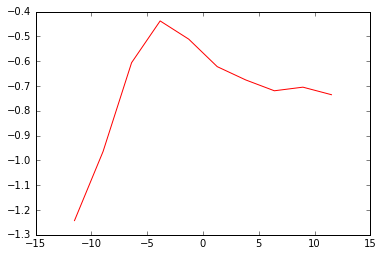

In [ ]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])
error[-1]

In [ ]:
data_train

In [ ]:
error=[]
i=0
q
for c in np.logspace(-5,5,10):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    svmlinear = svm.SVC(C=c, kernel='poly')
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

0


In [ ]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])
error[-1]

In [15]:
error=[]
i=0

for c in np.logspace(-5,5,10):
    #print("Printing penalty")
    #print(c)
    print(i)
    i=i+1
    svmlinear = svm.SVC(C=c, kernel='rbf')
    
    svmlinear.fit(data_train, labels_train)
    error.append((c,sklearn.metrics.accuracy_score(labels_validation,svmlinear.predict(data_validation), normalize=True)))
    

0


KeyboardInterrupt: 

In [ ]:
plt.plot(*zip(*np.log(error)),c='r')

error.sort(key = lambda x: x[1])
error[-1]

# Trying out adaboost with logistic regression

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression



In [27]:
errors = []
for i in np.linspace(100,300,50):

    clf = AdaBoostClassifier(SGDClassifier(),n_estimators = 100, algorithm='SAMME')
    clf.fit(data_train,labels_train)
    acc=sklearn.metrics.accuracy_score(labels_test,clf.predict(data_test))
    
    errors.append((i,acc))
    


(283.67346938775512, 0.62225705329153602)

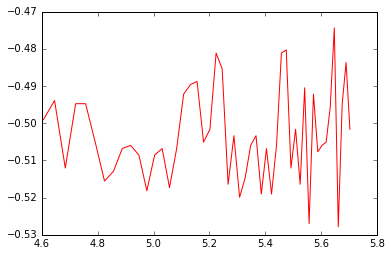

In [28]:
plt.plot(*zip(*np.log(errors)),c='r')

errors.sort(key = lambda x: x[1])
errors[-1]